In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
Pkg.instantiate()

using ForwardDiff
using LinearAlgebra
using Statistics
using Plots
plotlyjs()
using Printf
using Random
using DifferentialEquations

  Activating project at `/home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation`


In [60]:
const FD = ForwardDiff;

PLOTS_DEFAULTS = Dict(:dpi => 600);

include("GeneralizedFunctionality/est_parameters.jl");
include("GeneralizedFunctionality/hybrid_system_simulation_tools.jl")
include("GeneralizedFunctionality/SKF_general.jl")
include("GeneralizedFunctionality/batch_estimation.jl")
include("GeneralizedFunctionality/generalized_saltation_calculations.jl")
include("DynamicSystems/bouncing_ball.jl") # Defines hybrid system functions
include("DynamicSystems/biped.jl") # Defines hybrid system functions

#Falling ball system definition
# dynamics = [balldynamics,balldynamics]
dynamics = [biped_dynamics_3link,biped_dynamics_2link]
resets = [[idReset,kneeReset],[heelReset,idReset]]
guards = [[idGuard,kneeGuard],[heelGuard,idGuard]]

2-element Vector{Vector{Function}}:
 [idGuard, kneeGuard]
 [heelGuard, idGuard]

In [61]:
#Definining initial states
mode0 = 1
# Σ = Diagonal([0.05,0.05,0.001,0.001])*1
Σ = Diagonal([0.05,0.05,0.001,0.001,1,1])*0
# xmean = [0.0,3.0,0.5,-5.0]

q1 = 0.1877
q2 = -0.2884
q3 = q2
q̇1 = -1.1014
q̇2 = 0.0399
q̇3 = q̇2

xmean = [q1, q2, q3, q̇1, q̇2, q̇3]

#Simulation times
t = 1.0 #10
dt = .01 #.1

#noise and measurement parameters
W = 0
V = 0
C = 1

#structure of all this
param = ESTParameters(C,V,W,dt,dynamics,resets,guards)

ESTParameters(1, 0, 0, 0.01, Function[biped_dynamics_3link, biped_dynamics_2link], Vector{Function}[[idReset, kneeReset], [heelReset, idReset]], Vector{Function}[[idGuard, kneeGuard], [heelGuard, idGuard]])

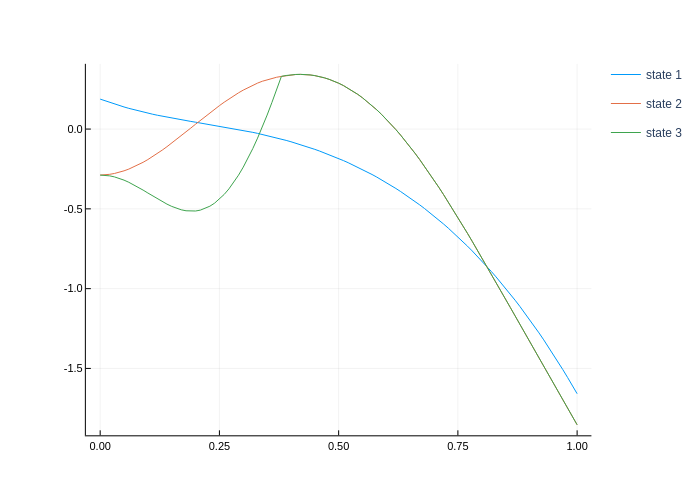

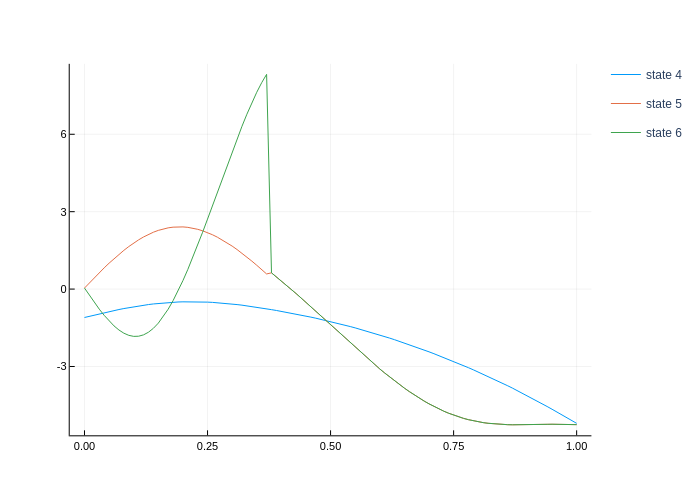

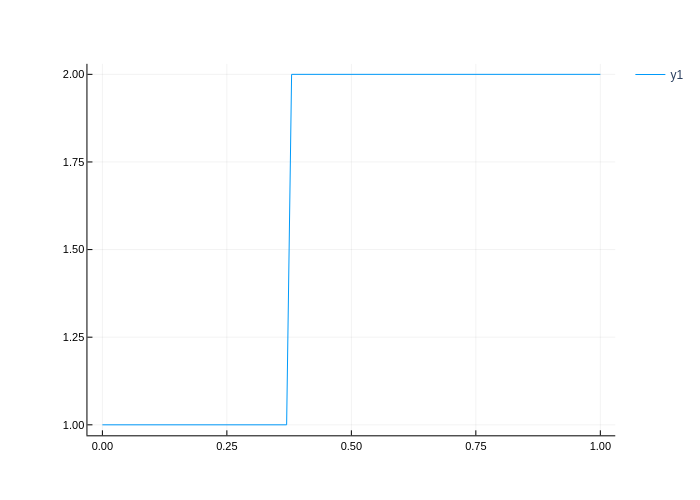

┌ Info: Saved animation to 
│   fn = /home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation/src/walker.gif
└ @ Plots /root/.julia/packages/Plots/NQpB8/src/animation.jl:114


Plots.AnimatedGif("/home/sman/Work/CMU/Courses/OCRL/OCRL-Walker-Project/juliaImplementation/juliaImplementation/src/walker.gif")
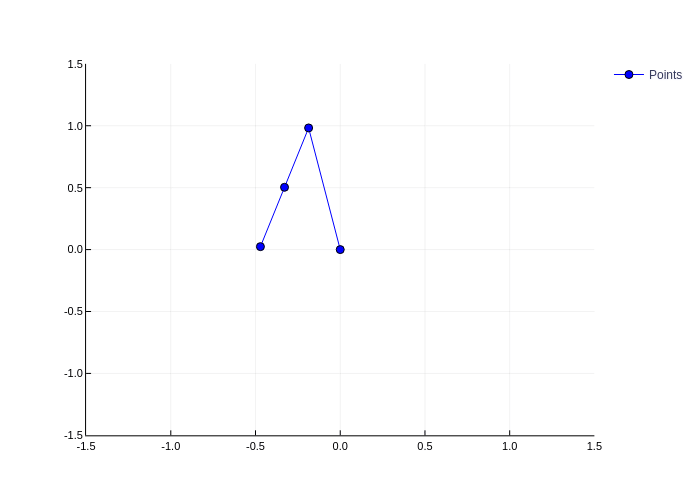

In [62]:
#Nominal Trajectory

nom_states, _, times, nom_modes,nom_impact_states,_ = sim_system(xmean,mode0,dynamics,resets,guards,W*.000000000000001,V,C,t,dt)
state_matrix = hcat(nom_states...)

plot()
for i in 1:3
    plot!(times,state_matrix[i,:], label = "state $i")
end
display(plot!())

plot()
for i in 4:6
    plot!(times,state_matrix[i,:], label = "state $i")
end
display(plot!())

plot(times, nom_modes)
display(plot!())

# Initialize an Animation object
anim = Animation()
lim = 1.5
# Loop to create frames
for i in 1:100
    js = hcat(q2joints(state_matrix[:,i])...)
    # Plot the data
    plot(js[1,:], js[2,:], xlim=(-lim,lim), ylim=(-lim,lim), label="Points", color="blue", linestyle=:solid, marker=:circle)
    # Add frame to animation
    frame(anim)
end
# Save the animation as a gif
gif(anim, "walker.gif", fps = 15)

In [ ]:
# #Noisy Trajectory & Single Kalman Filter Solve
# Random.seed!(1) # get a trial consistently
# xstart = xmean + sqrt(Σ)*randn(size(xmean))

# states, measurements = sim_system(xstart,mode0,dynamics,resets,guards,W,V,C,t,dt)
# est_states, _ = skf(param,xmean,Σ,mode0,measurements)
# plot([state[1] for state in states],[state[2] for state in states],label="Ground Truth")
# plot!([state[1] for state in est_states],[state[2] for state in est_states],label="SKF Estimate")
# scatter!([meas[1] for meas in measurements],[meas[2] for meas in measurements],label="measurements")
# display(plot!())

# # Multiple Trials for SKF:
# iters = 10
# random_seed = 3

# avg_err, avg_step_err, avg_error, avgTime, step_err_kf = runMultipleKF(dynamics,resets,guards,W,V,C,xmean,Σ,mode0,t,dt;num_iters=iters,randseed=random_seed);

# display(plot(avg_step_err))